# Eke field for MW Qian experiments

In [1]:
import os

In [2]:
import cosima_cookbook as cc
from dask.distributed import Client
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import numpy as np
import xarray as xr
import cmocean as cm
import cartopy.crs as ccrs
import cmocean as cm
from xgcm import Grid
import glob

In [3]:
import matplotlib.dates as mdates
import datetime
import pandas as pd

In [4]:
%matplotlib inline

In [5]:
from matplotlib import rc
rc('font', **{'size':40})
rc('text', usetex=False)
rc('xtick', labelsize=40) #20 
rc('ytick', labelsize=40) #20
rc('axes', titlesize=40)    # fontsize of the axes title
rc('axes', labelsize=40) #24    # fontsize of the x and y labels

In [172]:
session=cc.database.create_session()

exp_ctrl= '01deg_jra55v13_ryf9091'
exp_wthmp= '01deg_jra55v13_ryf9091_qian_wthmp'
exp_wthp= '01deg_jra55v13_ryf9091_qian_wthp'
lat_lim = slice(-79, -60)
lon_lim = slice(-279.99,80)

#### SET EXPT HERE
expt = exp_ctrl


In [7]:
# We will use an annual average from 10 year in the RYF run
start_time_mw='2110-01-31 00:00:00' 
end_time_mw='2159-12-31 00:00:00'
start_time='1950-01-31 00:00:00'
end_time='1959-12-31 00:00:00'


from dask.distributed import Client

c=Client(local_directory = '/g/data/v45/qo9901/') 
c 

In [9]:
import dask.config
from dask.distributed import Client,LocalCluster
from dask_jobqueue import PBSCluster

walltime = '03:00:00'
cores = 28
memory = '252GB'

cluster = PBSCluster(walltime=str(walltime), cores=cores, memory=str(memory),processes=cores,
                     job_extra=['-q normalbw','-P v45','-l ncpus='+str(cores),'-l mem='+str(memory),
                                '-l storage=gdata/ik11+gdata/e14+gdata/hh5+gdata/v45+gdata/cj50',
                                '-l jobfs=400GB'],
                     local_directory='$TMPDIR',
                     header_skip=["select"],
                     #python=os.environ["DASK_PYTHON"]
                    )
cluster

# and if you want even more power, you can use this to make it three nodes
cluster.scale(jobs=3)

# then, run this to make a dask client

c = Client(cluster)
c

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: /proxy/34397/status,
Dashboard: /proxy/34397/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.6.121.63:41293,Workers: 0
Dashboard: /proxy/34397/status,Total threads: 0
Started: Just now,Total memory: 0 B


2024-07-10 11:50:57,156 - distributed.scheduler - ERROR - Task ('where-42e561e22acca803389b2531449b149f', 0, 0, 0) marked as failed because 4 workers died while trying to run it
2024-07-10 11:51:47,581 - distributed.scheduler - ERROR - Task ('where-42e561e22acca803389b2531449b149f', 0, 0, 0) marked as failed because 4 workers died while trying to run it
Task exception was never retrieved
future: <Task finished name='Task-1941602' coro=<Client._gather.<locals>.wait() done, defined at /g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/distributed/client.py:2197> exception=AllExit()>
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/distributed/client.py", line 2206, in wait
    raise AllExit()
distributed.client.AllExit


In [176]:
flex_period = slice(start_time_mw,end_time_mw)
flex_period = slice('2110','2159')

In [25]:
ee = cc.explore.ExperimentExplorer(session=session, experiment=expt)
ee

ExperimentExplorer(children=(HTML(value='\n            <h3>Experiment Explorer</h3>\n\n            <p>Select a…

In [11]:
hu = cc.querying.getvar(expt='01deg_jra55v13_ryf9091', variable='hu', 
                          session=session, frequency='static',
                          attrs={'cell_methods': 'time: point'}, n=1).sel(yu_ocean = slice(-79,-60))
hu

<xarray.DataArray 'hu' (yu_ocean: 440, xu_ocean: 3600)> Size: 6MB
dask.array<getitem, shape=(440, 3600), dtype=float32, chunksize=(440, 900), chunktype=numpy.ndarray>
Coordinates:
  * xu_ocean  (xu_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.8 79.9 80.0
  * yu_ocean  (yu_ocean) float64 4kB -78.98 -78.93 -78.89 ... -60.07 -60.02
    geolon_c  (yu_ocean, xu_ocean) float32 6MB dask.array<chunksize=(440, 900), meta=np.ndarray>
    geolat_c  (yu_ocean, xu_ocean) float32 6MB dask.array<chunksize=(440, 900), meta=np.ndarray>
Attributes:
    long_name:     ocean depth on u-cells
    units:         m
    valid_range:   [-1.e+09  1.e+09]
    cell_methods:  time: point
    ncfiles:       ['/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf909...
    contact:       Andy Hogg
    email:         andy.hogg@anu.edu.au
    created:       2020-06-11
    description:   0.1 degree ACCESS-OM2 global model configuration with JRA5...
    notes:         Additional daily outputs saved from 1 Jan 1950 to 31 Dec 1...
    url:           https://github.com/COSIMA/01deg_jra55_ryf/tree/01deg_jra55...

In [12]:
# NEEDload coordinates and grid specifications
geolat_t = cc.querying.getvar(expt, 'geolat_t', session=session, n=1)
geolon_t = cc.querying.getvar(expt, 'geolon_t', session=session, n=1)

dxt = cc.querying.getvar(expt=expt, variable='dxt', session=session, frequency='static', n=1)
dyt = cc.querying.getvar(expt=expt, variable='dyt', session=session, frequency='static', n=1)

dxu = cc.querying.getvar(expt=expt, variable='dxu', session=session, frequency='static', n=1)
dyu = cc.querying.getvar(expt=expt, variable='dyu', session=session, frequency='static', n=1)

In [13]:
import gc
c.run(gc.collect)

{'tcp://10.6.129.25:33355': 56,
 'tcp://10.6.129.25:33671': 56,
 'tcp://10.6.129.25:33705': 56,
 'tcp://10.6.129.25:33819': 191,
 'tcp://10.6.129.25:34689': 56,
 'tcp://10.6.129.25:34879': 56,
 'tcp://10.6.129.25:34927': 301,
 'tcp://10.6.129.25:35741': 56,
 'tcp://10.6.129.25:35749': 277,
 'tcp://10.6.129.25:35769': 316,
 'tcp://10.6.129.25:36371': 56,
 'tcp://10.6.129.25:37539': 56,
 'tcp://10.6.129.25:37775': 345,
 'tcp://10.6.129.25:37835': 56,
 'tcp://10.6.129.25:38839': 56,
 'tcp://10.6.129.25:39591': 285,
 'tcp://10.6.129.25:41189': 56,
 'tcp://10.6.129.25:41463': 56,
 'tcp://10.6.129.25:41791': 349,
 'tcp://10.6.129.25:41971': 56,
 'tcp://10.6.129.25:42201': 56,
 'tcp://10.6.129.25:43455': 56,
 'tcp://10.6.129.25:44259': 56,
 'tcp://10.6.129.25:44309': 56,
 'tcp://10.6.129.25:45071': 56,
 'tcp://10.6.129.25:45711': 56,
 'tcp://10.6.129.25:45767': 56,
 'tcp://10.6.129.25:46805': 56,
 'tcp://10.6.129.30:33145': 56,
 'tcp://10.6.129.30:35467': 56,
 'tcp://10.6.129.30:35621': 39,
 

In [14]:
flex_period

slice('2110', '2160', None)

In [15]:
#sea_level_lim = sea_level.sel( xt_ocean= lon_lim, yt_ocean=lat_lim, time = flex_period)

# coordinates
lat_t = geolat_t.sel( xt_ocean= lon_lim,yt_ocean=lat_lim)
lon_t = geolon_t.sel(xt_ocean= lon_lim, yt_ocean=lat_lim)

dxt_lim = dxt.sel(xt_ocean= lon_lim,yt_ocean=lat_lim)
dyt_lim = dyt.sel(xt_ocean= lon_lim,yt_ocean=lat_lim)

dxu_lim = dxu.sel(xu_ocean= lon_lim,yu_ocean=lat_lim)
dyu_lim = dyu.sel(xu_ocean= lon_lim,yu_ocean=lat_lim)

## Generate Surface geostrophic velocity -  transient

In [173]:
SSH = cc.querying.getvar(expt,'sea_level', session, frequency = '1 monthly').sel(yt_ocean = lat_lim)
SSH # no sea_level

Exception during reset or similar
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/sqlalchemy/pool/base.py", line 763, in _finalize_fairy
    fairy._reset(pool, transaction_was_reset)
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/sqlalchemy/pool/base.py", line 1038, in _reset
    pool._dialect.do_rollback(self)
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/sqlalchemy/engine/default.py", line 683, in do_rollback
    dbapi_connection.rollback()
sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 23096953665344 and this is thread id 23094539257600.
Exception closing connection <sqlite3.Connection object at 0x15011e50f340>
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/sit

<xarray.DataArray 'sea_level' (time: 3360, yt_ocean: 440, xt_ocean: 3600)> Size: 21GB
dask.array<getitem, shape=(3360, 440, 3600), dtype=float32, chunksize=(1, 440, 900), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 4kB -79.0 -78.95 -78.91 ... -60.15 -60.1 -60.05
  * time      (time) object 27kB 1900-01-16 12:00:00 ... 2179-12-16 12:00:00
Attributes: (12/13)
    long_name:      effective sea level (eta_t + patm/(rho0*g)) on T cells
    units:          meter
    valid_range:    [-1000.  1000.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_surface_height_above_geoid
    ...             ...
    contact:        Andy Hogg
    email:          andy.hogg@anu.edu.au
    created:        2020-06-11
    description:    0.1 degree ACCESS-OM2 global model configuration with JRA...
    notes:          Additional daily outputs saved from 1 Jan 1950 to 31 Dec ...
    url:            https://github.com/COSIMA/01deg_jra55_ryf/tree/01deg_jra5...

In [177]:
patm = 101000 #[Pa, N/m2]
rho0 = 1035 #[kg/m3]
g = 9.81 #[m/s2]
sea_level = SSH #+ patm/(rho0*g) 

#effective sea level (eta_t + patm/(rho0*g)) on T cells (meter)
sea_level = sea_level.chunk({ 'yt_ocean':69, 'xt_ocean':360, 'time':18250})
sea_level_lim = sea_level.sel( xt_ocean= lon_lim, yt_ocean=lat_lim, time = flex_period)


In [178]:
sea_level_lim

<xarray.DataArray 'sea_level' (time: 600, yt_ocean: 440, xt_ocean: 3600)> Size: 4GB
dask.array<getitem, shape=(600, 440, 3600), dtype=float32, chunksize=(600, 69, 360), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 4kB -79.0 -78.95 -78.91 ... -60.15 -60.1 -60.05
  * time      (time) object 5kB 2110-01-16 12:00:00 ... 2159-12-16 12:00:00
Attributes: (12/13)
    long_name:      effective sea level (eta_t + patm/(rho0*g)) on T cells
    units:          meter
    valid_range:    [-1000.  1000.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_surface_height_above_geoid
    ...             ...
    contact:        Andy Hogg
    email:          andy.hogg@anu.edu.au
    created:        2020-06-11
    description:    0.1 degree ACCESS-OM2 global model configuration with JRA...
    notes:          Additional daily outputs saved from 1 Jan 1950 to 31 Dec ...
    url:            https://github.com/COSIMA/01deg_jra55_ryf/tree/01deg_jra5...

In [179]:
# defining B-grid using xgcm
path_to_folder = '/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output000/ocean/'
ocean_grid = xr.open_mfdataset(path_to_folder+'ocean_grid.nc', combine='by_coords')

In [180]:
## need to run seperately or it will crash
import xgcm
coordinates = xr.merge([dxt_lim, dyt_lim, dxu_lim, dyu_lim])

# merge coordinates and variables in one dataset
#vel = xr.merge([coordinates, sea_level_lim.sel(time=flex_period), ocean_grid.sel(time = flex_period)])# time is flex_period before
#vel = xr.merge([coordinates, sea_level_lim.sel(time=flex_period)])#, ocean_grid.sel(time = flex_period)])# time is flex_period before

In [181]:
sea_level_lim.sel(time=flex_period)

<xarray.DataArray 'sea_level' (time: 600, yt_ocean: 440, xt_ocean: 3600)> Size: 4GB
dask.array<getitem, shape=(600, 440, 3600), dtype=float32, chunksize=(600, 69, 360), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 4kB -79.0 -78.95 -78.91 ... -60.15 -60.1 -60.05
  * time      (time) object 5kB 2110-01-16 12:00:00 ... 2159-12-16 12:00:00
Attributes: (12/13)
    long_name:      effective sea level (eta_t + patm/(rho0*g)) on T cells
    units:          meter
    valid_range:    [-1000.  1000.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_surface_height_above_geoid
    ...             ...
    contact:        Andy Hogg
    email:          andy.hogg@anu.edu.au
    created:        2020-06-11
    description:    0.1 degree ACCESS-OM2 global model configuration with JRA...
    notes:          Additional daily outputs saved from 1 Jan 1950 to 31 Dec ...
    url:            https://github.com/COSIMA/01deg_jra55_ryf/tree/01deg_jra5...

In [182]:
vel = xr.merge([coordinates, sea_level_lim.sel(time=flex_period), ocean_grid.sel(xt_ocean= lon_lim,xu_ocean= lon_lim, yt_ocean=lat_lim, yu_ocean = lat_lim).isel(time = 0)],compat='override')# time is flex_period before

In [183]:
vel.coords['xt_ocean'].attrs.update(axis='X')
vel.coords['xu_ocean'].attrs.update(axis='X', c_grid_axis_shift=0.5, periodic=False)
vel.coords['yt_ocean'].attrs.update(axis='Y')
vel.coords['yu_ocean'].attrs.update(axis='Y', c_grid_axis_shift=0.5)
metrics = {
    ('X',): ['dxt', 'dxu'], # X distances
    ('Y',): ['dyt', 'dyu'], # Y distances
    ('X', 'Y'): ['area_t', 'area_u'] # Areas
}

In [184]:
grid = xgcm.Grid(vel, periodic=False, metrics = metrics,boundary='extend')
grid

<xgcm.Grid>
X Axis (not periodic, boundary='extend'):
  * center   xt_ocean --> right
  * right    xu_ocean --> center
Y Axis (not periodic, boundary='extend'):
  * center   yt_ocean --> right
  * right    yu_ocean --> center

In [185]:
def geostrophic_velocity(ds, grid, sea_level='sea_level', stream_func='deltaD', gravity='gu', coriolis='f', delta_names=('dx', 'dy')):

    '''
    calculate geostrophic velocity from sea level
    '''
    
    # surface geostrophic velocity
    detadx = grid.interp(grid.diff(ds[sea_level], 'X', boundary='extend'), 'Y', boundary='extend') / ds[delta_names[0]] # , boundary='extend') for 'X'?
    detady = grid.interp(grid.diff(ds[sea_level], 'Y', boundary='extend'), 'X', boundary='extend') / ds[delta_names[1]]

    ds['ug_s']= - (ds[gravity] / ds[coriolis]) * detady
    ds['vg_s'] = (ds[gravity] / ds[coriolis]) * detadx

    ds['ug_s'].name = 'ug_s'
    ds['ug_s'].attrs['standard_name'] = 'surface_geostrophic_eastward_sea_water_velocity'
    ds['ug_s'].attrs['long_name'] = r'$u_g,s$'
    ds['ug_s'].attrs['units'] = r'$\mathrm{ms}^{-1}$'
    
    ds['vg_s'].name = 'vg_s'
    ds['vg_s'].attrs['standard_name'] = 'surface_geostrophic_northward_sea_water_velocity'
    ds['vg_s'].attrs['long_name'] = r'$v_g,s$'
    ds['vg_s'].attrs['units'] = r'$\mathrm{ms}^{-1}$'
    
    return ds

In [186]:
from gsw import f, grav, p_from_z

In [187]:
g = xr.apply_ufunc(grav, lat_t, patm, dask='parallelized') ## CHEKC IF Patm is riht for surface
## not allowed to leave p empty
g.name = 'g'
g.attrs = {'standard_name': 'gravitational_acceleration', 'units':r'$\textrm{ms}^{-2}$', 'long_name': 'gravitational acceleration'}

# Coriolis parameter
fcor, _ = xr.broadcast(f(coordinates.yu_ocean), coordinates.xu_ocean)
fcor.name = 'f'
fcor.attrs = {'standard_name': 'coriolis_parameter', 'units': r'$\textrm{s}^{-1}$', 'long_name': 'Coriolis parameter'}

gu = grid.interp(grid.interp(g, 'X', boundary='extend'), 'Y', boundary='extend') ## interpolated gravity to u grid
gu.name = 'gu'

In [188]:
sl_grd = xr.merge([coordinates, gu, fcor, sea_level_lim.sel(time=flex_period)])
sl_grd

<xarray.Dataset> Size: 4GB
Dimensions:    (xt_ocean: 3600, yt_ocean: 440, xu_ocean: 3600, yu_ocean: 440,
                time: 600)
Coordinates:
  * xt_ocean   (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.85 79.95
  * yt_ocean   (yt_ocean) float64 4kB -79.0 -78.95 -78.91 ... -60.1 -60.05
    geolon_t   (yt_ocean, xt_ocean) float32 6MB dask.array<chunksize=(440, 900), meta=np.ndarray>
    geolat_t   (yt_ocean, xt_ocean) float32 6MB dask.array<chunksize=(440, 900), meta=np.ndarray>
  * xu_ocean   (xu_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.8 79.9 80.0
  * yu_ocean   (yu_ocean) float64 4kB -78.98 -78.93 -78.89 ... -60.07 -60.02
    geolon_c   (yu_ocean, xu_ocean) float32 6MB dask.array<chunksize=(440, 900), meta=np.ndarray>
    geolat_c   (yu_ocean, xu_ocean) float32 6MB dask.array<chunksize=(440, 900), meta=np.ndarray>
  * time       (time) object 5kB 2110-01-16 12:00:00 ... 2159-12-16 12:00:00
Data variables:
    dxt        (yt_ocean, xt_ocean) float32 6MB dask.array<chunksize=(440, 900), meta=np.ndarray>
    dyt        (yt_ocean, xt_ocean) float32 6MB dask.array<chunksize=(440, 900), meta=np.ndarray>
    dxu        (yu_ocean, xu_ocean) float32 6MB dask.array<chunksize=(440, 900), meta=np.ndarray>
    dyu        (yu_ocean, xu_ocean) float32 6MB dask.array<chunksize=(440, 900), meta=np.ndarray>
    gu         (yu_ocean, xu_ocean) float64 13MB dask.array<chunksize=(440, 900), meta=np.ndarray>
    f          (yu_ocean, xu_ocean) float64 13MB -0.0001432 ... -0.0001263
    sea_level  (time, yt_ocean, xt_ocean) float32 4GB dask.array<chunksize=(600, 69, 360), meta=np.ndarray>
Attributes:
    long_name:     ocean dxt on t-cells
    units:         m
    valid_range:   [-1.e+09  1.e+09]
    cell_methods:  time: point
    ncfiles:       ['/g/data/cj50/access-om2/raw-output/access-om2-01/01deg_j...

Now, we just have to provide the function geostrophic_velocity with the variables in the Dataset, the Grid made with xgcm, we set stream_func to None, because we only calculate the geostrophic velocities at the surface and we provide the names of dx and dy in the Dataset.

In [189]:
sl_grd = sl_grd.chunk({'yt_ocean':93,'xt_ocean':600})#makexy domain one chunk only

In [190]:
geos_vel = geostrophic_velocity(sl_grd, grid, stream_func=None, delta_names=('dxu', 'dyu'))

# calculating the geostrophic flow speed
Vg = (geos_vel.ug_s**2 + geos_vel.vg_s**2)**(1/2)

In [191]:
Vg = Vg.chunk({ 'yu_ocean':69, 'xu_ocean':60, 'time':5000})
u = geos_vel.ug_s.sel(yu_ocean=lat_lim, xu_ocean = lon_lim)#.chunk({ 'yu_ocean':69, 'xu_ocean':60, 'time':5000})#.mean('time')
v = geos_vel.vg_s.sel(yu_ocean=lat_lim, xu_ocean = lon_lim)#.chunk({ 'yu_ocean':69, 'xu_ocean':60, 'time':5000})#.mean('time')

In [192]:
u.load()

<xarray.DataArray 'ug_s' (yu_ocean: 440, xu_ocean: 3600, time: 600)> Size: 8GB
array([[[            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        ...,
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan]],

       [[            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
...
        [-5.59031850e-03, -1.08693080e-02,  4.08215755e-03, ...,
         -1.07439251e-01, -8.22955789e-02, -1.08300091e-01],
        [-4.16551879e-03, -7.28561733e-03,  1.74548600e-03, ...,
         -9.67613339e-02, -7.05024918e-02, -9.89321336e-02],
        [-4.03197051e-03, -5.56650084e-03,  9.18676809e-05, ...,
         -9.13913272e-02, -6.50729407e-02, -9.43310966e-02]],

       [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        ...,
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00]]])
Coordinates:
  * xu_ocean  (xu_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.8 79.9 80.0
  * yu_ocean  (yu_ocean) float64 4kB -78.98 -78.93 -78.89 ... -60.07 -60.02
    geolon_c  (yu_ocean, xu_ocean) float32 6MB nan nan nan ... 79.8 79.9 80.0
    geolat_c  (yu_ocean, xu_ocean) float32 6MB nan nan nan ... -60.02 -60.02
  * time      (time) object 5kB 2110-01-16 12:00:00 ... 2159-12-16 12:00:00
Attributes:
    standard_name:  surface_geostrophic_eastward_sea_water_velocity
    long_name:      $u_g,s$
    units:          $\mathrm{ms}^{-1}$

In [193]:
v.load()

<xarray.DataArray 'vg_s' (yu_ocean: 440, xu_ocean: 3600, time: 600)> Size: 8GB
array([[[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
...
        [-0.01000335, -0.00428715,  0.01120358, ...,  0.06190338,
          0.02711537,  0.02483825],
        [-0.01212566, -0.0116374 , -0.00065498, ...,  0.04998187,
          0.02212901,  0.02569143],
        [-0.        , -0.        , -0.        , ..., -0.        ,
         -0.        , -0.        ]],

       [[-0.0144256 , -0.02064248, -0.02105887, ...,  0.03095353,
          0.0090347 ,  0.01836511],
        [-0.01412479, -0.01945621, -0.02919111, ...,  0.02737262,
          0.00658568,  0.01586171],
        [-0.01124578, -0.01606395, -0.02970267, ...,  0.02615405,
          0.00646331,  0.0176836 ],
        ...,
        [-0.01128317, -0.0061455 ,  0.01187461, ...,  0.05653824,
          0.02073086,  0.02005104],
        [-0.01224681, -0.013343  ,  0.00099762, ...,  0.04456675,
          0.01668258,  0.02106906],
        [-0.        , -0.        , -0.        , ..., -0.        ,
         -0.        , -0.        ]]])
Coordinates:
  * xu_ocean  (xu_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.8 79.9 80.0
  * yu_ocean  (yu_ocean) float64 4kB -78.98 -78.93 -78.89 ... -60.07 -60.02
    geolon_c  (yu_ocean, xu_ocean) float32 6MB nan nan nan ... 79.8 79.9 80.0
    geolat_c  (yu_ocean, xu_ocean) float32 6MB nan nan nan ... -60.02 -60.02
  * time      (time) object 5kB 2110-01-16 12:00:00 ... 2159-12-16 12:00:00
Attributes:
    standard_name:  surface_geostrophic_northward_sea_water_velocity
    long_name:      $v_g,s$
    units:          $\mathrm{ms}^{-1}$

In [194]:
expt

'01deg_jra55v13_ryf9091'

In [195]:
v.to_netcdf('/g/data/v45/qo9901/MW-perturb-ASC-data/v_monthly_field' + expt +'.nc')

In [196]:
u.to_netcdf('/g/data/v45/qo9901/MW-perturb-ASC-data/u_monthly_field' + expt +'.nc')

In [55]:
## testing daily time series for control ryf
u_test = xr.open_mfdataset('/g/data/v45/qo9901/RYF_plotting/u_daily_field.nc')

In [57]:
u_test

<xarray.Dataset> Size: 25GB
Dimensions:   (xu_ocean: 400, yu_ocean: 93, time: 83860)
Coordinates:
  * xu_ocean  (xu_ocean) float64 3kB -270.0 -269.9 -269.8 ... -230.2 -230.1
  * yu_ocean  (yu_ocean) float64 744B -66.98 -66.94 -66.9 ... -63.07 -63.02
    geolon_c  (yu_ocean, xu_ocean) float32 149kB dask.array<chunksize=(93, 400), meta=np.ndarray>
    geolat_c  (yu_ocean, xu_ocean) float32 149kB dask.array<chunksize=(93, 400), meta=np.ndarray>
  * time      (time) object 671kB 1950-01-01 12:00:00 ... 2179-12-31 12:00:00
Data variables:
    ug_s      (yu_ocean, xu_ocean, time) float64 25GB dask.array<chunksize=(93, 400, 83860), meta=np.ndarray>

# Loading in everything for Circ ACCESS

In [197]:
u = xr.open_mfdataset('/g/data/v45/qo9901/MW-perturb-ASC-data/u_monthly_field' + expt +'.nc').ug_s#.sel(time = flex_period) #.chunk({ 'yu_ocean':69, 'xu_ocean':60, 'time':5000})
v = xr.open_mfdataset('/g/data/v45/qo9901/MW-perturb-ASC-data/v_monthly_field' + expt +'.nc').vg_s#.sel(time = flex_period) #.chunk({ 'yu_ocean':69, 'xu_ocean':60, 'time':5000})
#u = xr.open_mfdataset('/g/data/v45/qo9901/RYF_plotting/u_daily_field.nc').ug_s.sel(time = flex_period) # RYf
#v = xr.open_mfdataset('/g/data/v45/qo9901/RYF_plotting/v_daily_field.nc').vg_s.sel(time = flex_period)
dhu_dx = xr.open_mfdataset('/g/data/v45/qo9901/RYF_plotting/dhu_dx_field.nc').__xarray_dataarray_variable__#.chunk({ 'yu_ocean':69, 'xu_ocean':60})
dhu_dy = xr.open_mfdataset('/g/data/v45/qo9901/RYF_plotting/dhu_dy_field.nc').__xarray_dataarray_variable__#.chunk({ 'yu_ocean':69, 'xu_ocean':60})
slope = xr.open_mfdataset('/g/data/v45/qo9901/RYF_plotting/slope_field.nc').__xarray_dataarray_variable__

In [198]:
u#.isel(time = 0).plot.contourf()

<xarray.DataArray 'ug_s' (yu_ocean: 440, xu_ocean: 3600, time: 600)> Size: 8GB
dask.array<open_dataset-ug_s, shape=(440, 3600, 600), dtype=float64, chunksize=(440, 3600, 600), chunktype=numpy.ndarray>
Coordinates:
  * xu_ocean  (xu_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.8 79.9 80.0
  * yu_ocean  (yu_ocean) float64 4kB -78.98 -78.93 -78.89 ... -60.07 -60.02
    geolon_c  (yu_ocean, xu_ocean) float32 6MB dask.array<chunksize=(440, 3600), meta=np.ndarray>
    geolat_c  (yu_ocean, xu_ocean) float32 6MB dask.array<chunksize=(440, 3600), meta=np.ndarray>
  * time      (time) object 5kB 2110-01-16 12:00:00 ... 2159-12-16 12:00:00
Attributes:
    standard_name:  surface_geostrophic_eastward_sea_water_velocity
    long_name:      $u_g,s$
    units:          $\mathrm{ms}^{-1}$

## start getting grid to do ssh maps

In [199]:
# defining B-grid using xgcm
path_to_folder = '/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output000/ocean/'
ocean_grid = xr.open_mfdataset(path_to_folder+'ocean_grid.nc', combine='by_coords')

In [200]:
## need to run seperately or it will crash
import xgcm
coordinates = xr.merge([dxt_lim, dyt_lim, dxu_lim, dyu_lim])

# merge coordinates and variables in one dataset
#vel = xr.merge([coordinates, sea_level_lim.sel(time=flex_period), ocean_grid.sel(time = flex_period)])# time is flex_period before
#vel = xr.merge([coordinates, sea_level_lim.sel(time=flex_period)])#, ocean_grid.sel(time = flex_period)])# time is flex_period before

In [201]:
vel = xr.merge([coordinates, u.sel(time=flex_period), v.sel(time=flex_period), ocean_grid.sel(xt_ocean= lon_lim,xu_ocean= lon_lim, yt_ocean=lat_lim, yu_ocean = lat_lim).isel(time = 0)],compat='override')# time is flex_period before

In [202]:
vel

<xarray.Dataset> Size: 15GB
Dimensions:     (xt_ocean: 3600, yt_ocean: 440, xu_ocean: 3600, yu_ocean: 440,
                 time: 600)
Coordinates:
  * xt_ocean    (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.85 79.95
  * yt_ocean    (yt_ocean) float64 4kB -79.0 -78.95 -78.91 ... -60.1 -60.05
    geolon_t    (yt_ocean, xt_ocean) float32 6MB dask.array<chunksize=(440, 900), meta=np.ndarray>
    geolat_t    (yt_ocean, xt_ocean) float32 6MB dask.array<chunksize=(440, 900), meta=np.ndarray>
  * xu_ocean    (xu_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.8 79.9 80.0
  * yu_ocean    (yu_ocean) float64 4kB -78.98 -78.93 -78.89 ... -60.07 -60.02
    geolon_c    (yu_ocean, xu_ocean) float32 6MB dask.array<chunksize=(440, 900), meta=np.ndarray>
    geolat_c    (yu_ocean, xu_ocean) float32 6MB dask.array<chunksize=(440, 900), meta=np.ndarray>
  * time        (time) object 5kB 2110-01-16 12:00:00 ... 2159-12-16 12:00:00
Data variables: (12/13)
    dxt         (yt_ocean, xt_ocean) float32 6MB dask.array<chunksize=(440, 900), meta=np.ndarray>
    dyt         (yt_ocean, xt_ocean) float32 6MB dask.array<chunksize=(440, 900), meta=np.ndarray>
    dxu         (yu_ocean, xu_ocean) float32 6MB dask.array<chunksize=(440, 900), meta=np.ndarray>
    dyu         (yu_ocean, xu_ocean) float32 6MB dask.array<chunksize=(440, 900), meta=np.ndarray>
    ug_s        (yu_ocean, xu_ocean, time) float64 8GB dask.array<chunksize=(440, 3600, 600), meta=np.ndarray>
    vg_s        (yu_ocean, xu_ocean, time) float64 8GB dask.array<chunksize=(440, 3600, 600), meta=np.ndarray>
    ...          ...
    hu          (yu_ocean, xu_ocean) float32 6MB dask.array<chunksize=(440, 900), meta=np.ndarray>
    area_t      (yt_ocean, xt_ocean) float32 6MB dask.array<chunksize=(440, 900), meta=np.ndarray>
    area_u      (yu_ocean, xu_ocean) float32 6MB dask.array<chunksize=(440, 900), meta=np.ndarray>
    kmt         (yt_ocean, xt_ocean) float32 6MB dask.array<chunksize=(440, 900), meta=np.ndarray>
    kmu         (yu_ocean, xu_ocean) float32 6MB dask.array<chunksize=(440, 900), meta=np.ndarray>
    drag_coeff  (yu_ocean, xu_ocean) float32 6MB dask.array<chunksize=(440, 900), meta=np.ndarray>
Attributes:
    long_name:     ocean dxt on t-cells
    units:         m
    valid_range:   [-1.e+09  1.e+09]
    cell_methods:  time: point
    ncfiles:       ['/g/data/cj50/access-om2/raw-output/access-om2-01/01deg_j...

In [203]:
vel.coords['xt_ocean'].attrs.update(axis='X')
vel.coords['xu_ocean'].attrs.update(axis='X', c_grid_axis_shift=0.5, periodic=False)
vel.coords['yt_ocean'].attrs.update(axis='Y')
vel.coords['yu_ocean'].attrs.update(axis='Y', c_grid_axis_shift=0.5)
metrics = {
    ('X',): ['dxt', 'dxu'], # X distances
    ('Y',): ['dyt', 'dyu'], # Y distances
    ('X', 'Y'): ['area_t', 'area_u'] # Areas
}

In [204]:
grid = xgcm.Grid(vel, periodic=False, metrics = metrics,boundary='extend')
grid

<xgcm.Grid>
X Axis (not periodic, boundary='extend'):
  * center   xt_ocean --> right
  * right    xu_ocean --> center
Y Axis (not periodic, boundary='extend'):
  * center   yt_ocean --> right
  * right    yu_ocean --> center

In [205]:
hu_region = hu.sel( yu_ocean = lat_lim, xu_ocean = lon_lim)

## EKE calculation

In [206]:
%%time
## coarsen monthly because no daily eke
u_reshape_arr = []
for xx in range(0,6):
    u_chunk = u.isel(xu_ocean = slice(xx*600,600*(xx+1))).chunk({ 'yu_ocean':69, 'xu_ocean':60, 'time':5000})
    u_reshape_elem = u_chunk.coarsen(time=12).construct(time=('year', 'month')).mean('year').load()
    u_reshape_arr.append(u_reshape_elem)

CPU times: user 11.9 s, sys: 1.77 s, total: 13.7 s
Wall time: 38.1 s


In [207]:
u_reshape = xr.merge(u_reshape_arr)

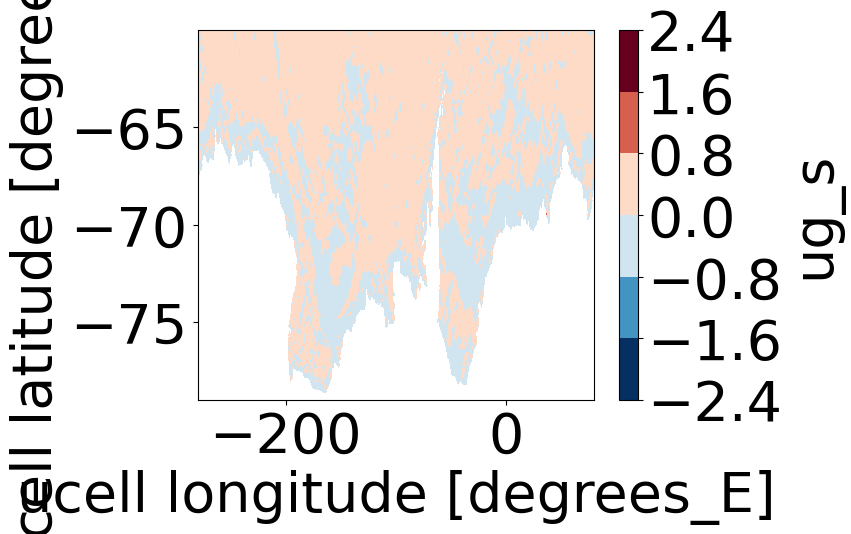

In [208]:
u_reshape.isel(month = 0).ug_s.plot.contourf()

In [209]:
%%time

v_reshape_arr = []
for xx in range(0,6):
    v_chunk = v.isel(xu_ocean = slice(xx*600,600*(xx+1))).chunk({ 'yu_ocean':69, 'xu_ocean':60, 'time':5000})
    v_reshape_elem = v_chunk.coarsen(time=12).construct(time=('year', 'month')).mean('year').load()
    v_reshape_arr.append(v_reshape_elem)

CPU times: user 13.4 s, sys: 1.68 s, total: 15.1 s
Wall time: 36.8 s


In [210]:
v_reshape = xr.merge(v_reshape_arr)

In [ ]:
%%time
print('EKE calculating')
rho_0 = 1035 #[kg m-3]
EKE_matrix = []
# iterating in longitude   .chunk({'time':1000, 'xu_ocean':100, 'yu_ocean':200})
for xx in range(12): # up to 12
    c.run(gc.collect)
    
    u_transient_clim = u.isel(xu_ocean = slice(xx*300, (xx+1)*300)).groupby( 'time.month') - u_reshape.isel(xu_ocean = slice(xx*300, (xx+1)*300))
    v_transient_clim = v.isel(xu_ocean = slice(xx*300, (xx+1)*300)).groupby( 'time.month') - v_reshape.isel(xu_ocean = slice(xx*300, (xx+1)*300))
    
    u_transientsel = u_transient_clim.load()#.where(mask_bath_shelf == True)#.where(mask_bath_slopeshelf == True).where(mask_East == True)#.load()#.sel(xu_ocean = slice(ASC_slice_rect[i][1][1], ASC_slice_rect[i][2][1]), yu_ocean = slice(ASC_slice_rect[i][1][0], ASC_slice_rect[i][2][0])).load()
    print('loaded u')
    c.run(gc.collect)
    
    v_transientsel = v_transient_clim.load()#.where(mask_bath_shelf == True)#.where(mask_bath_slopeshelf == True).where(mask_East == True)#.load()#.sel(xu_ocean = slice(ASC_slice_rect[i][1][1], ASC_slice_rect[i][2][1]), yu_ocean = slice(ASC_slice_rect[i][1][0], ASC_slice_rect[i][2][0])).load()
    print('loaded v')
    
    EKE = 0.5*rho_0*(u_transientsel.ug_s**2 + v_transientsel.vg_s**2)#.load()
    print('loaded %i' ,xx)
    EKE_matrix.append(EKE)

EKE calculating
loaded u
loaded v
loaded %i 0
loaded u
loaded v
loaded %i 1
loaded u
loaded v
loaded %i 2
loaded u
loaded v
loaded %i 3
loaded u
loaded v
loaded %i 4
loaded u
loaded v
loaded %i 5
loaded u
loaded v
loaded %i 6
loaded u
loaded v
loaded %i 7
loaded u
loaded v
loaded %i 8
loaded u
loaded v
loaded %i 9
loaded u
loaded v
loaded %i 10
loaded u
loaded v


In [ ]:
EKE_ds = [EKE_matrix[i].to_dataset(name = 'EKE') for i in range(12)]
EKE_ds

In [ ]:
EKE_ds #[0].EKE

In [ ]:
%%time
EKE_field_1 = xr.concat(EKE_ds[:4], dim = 'xu_ocean')
EKE_field_2 = xr.concat(EKE_ds[4:8], dim = 'xu_ocean')
EKE_field_3 = xr.concat(EKE_ds[8:12], dim = 'xu_ocean')

In [ ]:
EKE_field = xr.concat([EKE_field_1,EKE_field_2,EKE_field_3], dim = 'xu_ocean')
EKE_field

In [ ]:
EKE_field.EKE.isel(time = 3).plot.contourf()

In [59]:
EKE_field.to_netcdf('/g/data/v45/qo9901/MW-perturb-ASC-data/EKEsurf_monthly_accessom201_'+ expt + '.nc')

# Making mask-- can skip

In [32]:
EKE_field = xr.open_mfdataset('/g/data/v45/qo9901/RYF_plotting/EKEsurf_accessom201_ryf_lat7960_20002010yr.nc')

In [185]:
EKE_field.time

<xarray.DataArray 'time' (time: 4015)>
array([cftime.DatetimeNoLeap(2000, 1, 1, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2000, 1, 2, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2000, 1, 3, 12, 0, 0, 0, has_year_zero=True), ...,
       cftime.DatetimeNoLeap(2010, 12, 29, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2010, 12, 30, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2010, 12, 31, 12, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
    dayofyear  (time) int64 dask.array<chunksize=(4015,), meta=np.ndarray>
  * time       (time) object 2000-01-01 12:00:00 ... 2010-12-31 12:00:00
Attributes:
    long_name:       time
    cartesian_axis:  T
    calendar_type:   NOLEAP
    bounds:          time_bounds

In [33]:
mask_slopeshelf = xr.where(hu <2500,True, False)
mask_slopeshelf

<xarray.DataArray 'hu' (yu_ocean: 440, xu_ocean: 3600)>
dask.array<where, shape=(440, 3600), dtype=bool, chunksize=(440, 900), chunktype=numpy.ndarray>
Coordinates:
  * xu_ocean  (xu_ocean) float64 -279.9 -279.8 -279.7 -279.6 ... 79.8 79.9 80.0
  * yu_ocean  (yu_ocean) float64 -78.98 -78.93 -78.89 ... -60.12 -60.07 -60.02
    geolon_c  (yu_ocean, xu_ocean) float32 dask.array<chunksize=(440, 900), meta=np.ndarray>
    geolat_c  (yu_ocean, xu_ocean) float32 dask.array<chunksize=(440, 900), meta=np.ndarray>

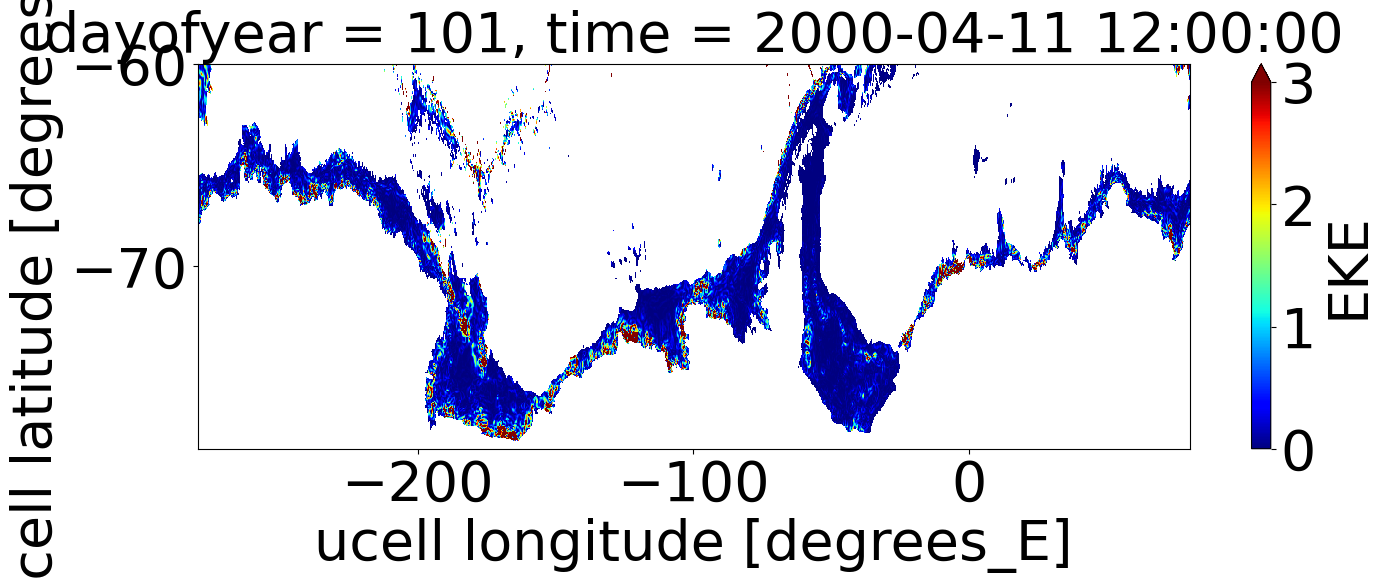

In [34]:
plt.figure(figsize = (16,5))
EKE_field.isel(time = 100).where(mask_slopeshelf == True).EKE.plot(vmax = 3, cmap = 'jet')

In [176]:
#gpt
from scipy.ndimage import label, find_objects

# Convert the numpy array to an xarray DataArray
#mask = xr.DataArray(data)

# Use scipy.ndimage to label the clusters
labeled_array, num_features = label(mask_slopeshelf)

# Find the sizes of each cluster
cluster_sizes = np.bincount(labeled_array.ravel())

n = 3 # top n biggest clusters
for nn in range(1,n+1):
    print(nn)
    # Ignore the background (label 0), find the largest cluster
    cluster_label = cluster_sizes[1:].argmax() + 1
    if nn > 1:
        cluster_label = cluster_sizes[1:].argsort()[-nn] + 1 # selecting nn largest cluster index, +1 as background ignored
        print('cluster_label = ' + str(cluster_label))
    # Create a new mask that only contains the largest cluster
    cluster_mask = (labeled_array == cluster_label)
    if nn > 1:
        combine_arr = np.ma.mask_or(cluster_mask_prev, cluster_mask)
        print(combine_arr)
        cluster_mask_prev = combine_arr
    else:
        cluster_mask_prev = cluster_mask
    print('done ' + str(nn))

# Convert the result back to an xarray DataArray, combining all n clusters
largest_cluster_mask_xr = xr.DataArray(combine_arr)
#two_cluster_mask_xr = xr.DataArray(secondlargest_cluster_mask)

largest_cluster_mask_xr = largest_cluster_mask_xr.rename({'dim_0': 'yu_ocean', 'dim_1':'xu_ocean'})
largest_cluster_mask_xr

1
done 1
2
cluster_label = 14
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
done 2
3
cluster_label = 2
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
done 3


<xarray.DataArray (yu_ocean: 440, xu_ocean: 3600)>
array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])
Dimensions without coordinates: yu_ocean, xu_ocean

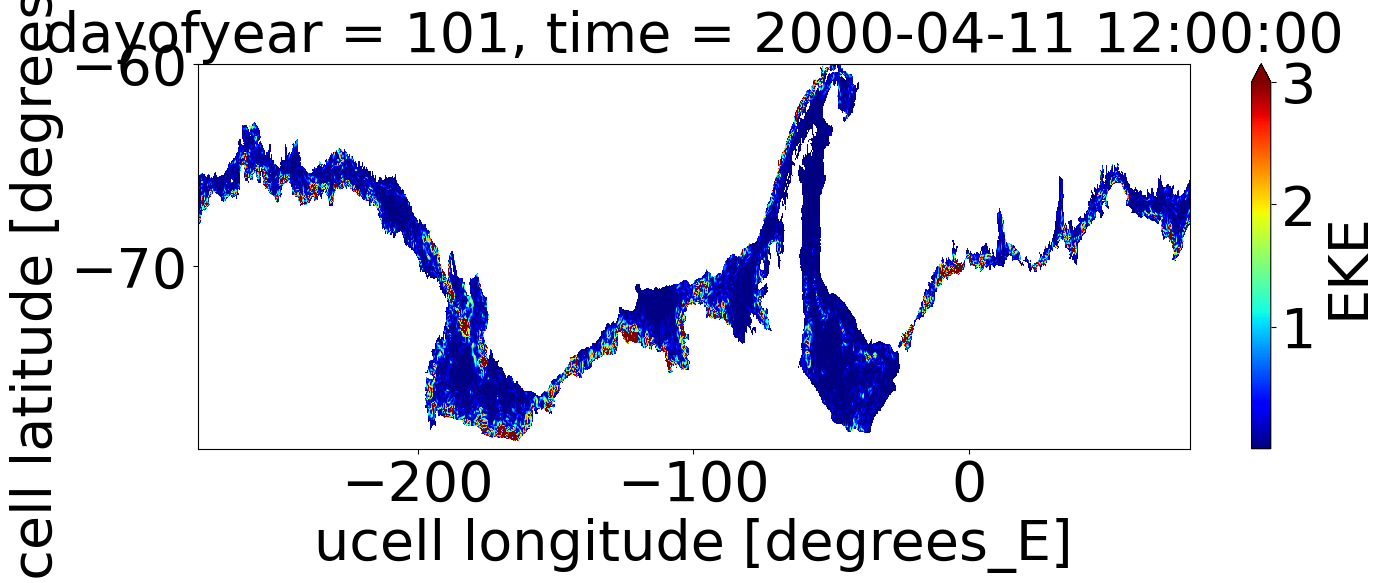

In [177]:
plt.figure(figsize = (16,5))
EKE_field.isel(time = 100).where(largest_cluster_mask_xr == True).EKE.plot(vmax = 3, cmap = 'jet')

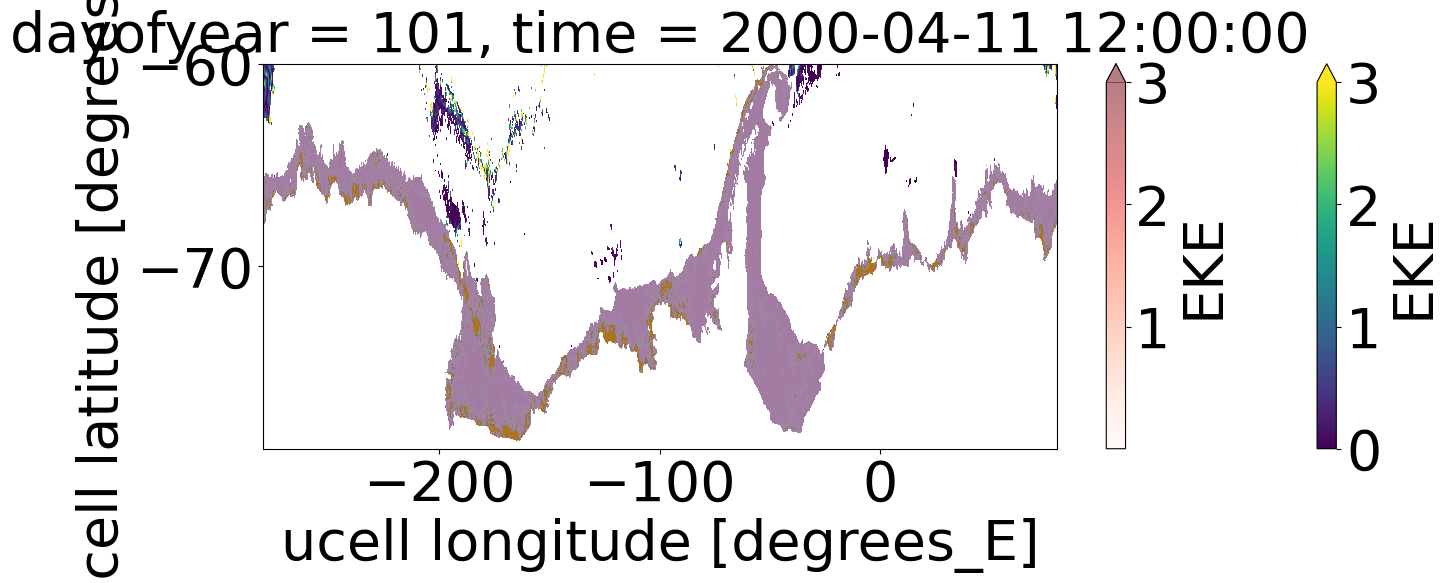

In [238]:
## showing the included and excluded regions 
plt.figure(figsize = (16,5))
EKE_field.isel(time = 100).where(mask_slopeshelf ==True).EKE.plot(vmax = 3)
EKE_field.isel(time = 100).where(largest_cluster_mask_xr ==True).EKE.plot(alpha = 0.5, vmax = 3, cmap = 'Reds')

In [179]:
largest_cluster_mask_xr.to_netcdf('largest_3cluster_mask_xr_accessom201.nc')

# Making EKE time series -- can start from here

In [60]:
grid

<xgcm.Grid>
X Axis (not periodic, boundary='extend'):
  * center   xt_ocean --> right
  * right    xu_ocean --> center
Y Axis (not periodic, boundary='extend'):
  * center   yt_ocean --> right
  * right    yu_ocean --> center

In [64]:
cluster_mask_access = xr.open_mfdataset('Antarctic-Eddy-Res-Compare/largest_3cluster_mask_xr_accessom201.nc')
area_u = cc.querying.getvar(expt='01deg_jra55v13_ryf9091', variable='area_u', 
                          session=session, frequency='static',
                          attrs={'cell_methods': 'time: point'}, n=1).sel(xu_ocean= lon_lim, yu_ocean = lat_lim)

In [113]:
cluster_mask_access.load()

<xarray.Dataset> Size: 2MB
Dimensions:                        (yu_ocean: 440, xu_ocean: 3600)
Dimensions without coordinates: yu_ocean, xu_ocean
Data variables:
    __xarray_dataarray_variable__  (yu_ocean, xu_ocean) bool 2MB False ... False

In [61]:
mask_shelf = xr.where(hu<1000 , True, False)
mask_slope = xr.where(hu>1000, True, False)

In [165]:
## change masked region in question
region = 'Shelf region'
## Change the above line

if region == 'Slope region':
    mask_region = mask_slope
elif region == 'Shelf region':
    mask_region = mask_shelf


In [166]:
def calc_EKE_circ_mask(expt, mask_region):
    EKE_field = xr.open_mfdataset('/g/data/v45/qo9901/MW-perturb-ASC-data/EKEsurf_monthly_accessom201_'+ expt + '.nc')#.EKE
    EKE_t = []
    for n in range(3):
        #speed = np.sqrt(u_field.isel(time = slice(200*n, 200*(n+1)))**2 + v_field.isel(time = slice(200*n, 200*(n+1)))**2).where(cluster_mask_access == True).where(mask_region ==True)
        #speed_depthav = speed.weighted(thickness_arr).mean(dim = 'st_ocean')
        circ_area = (area_u*cluster_mask_access.where(mask_region ==True)).sum().__xarray_dataarray_variable__.values                                                                                                                                                                                           
    
        EKE_elem = grid.integrate(EKE_field.isel(time = slice(n*200,(n+1)*200)).EKE.where(cluster_mask_access == True).__xarray_dataarray_variable__.where(mask_region ==True), axis = ('X','Y')).load()
        EKE_t.append(EKE_elem.to_dataset(name='EKE')/circ_area)
        print(n ,' is done')
        EKE_merge = xr.merge(EKE_t)
    return EKE_merge

In [ ]:
EKE_ryf = calc_EKE_circ_mask(exp_ryf, mask_region)

In [167]:
EKE_wthmp = calc_EKE_circ_mask(exp_wthmp, mask_region)
EKE_wthp = calc_EKE_circ_mask(exp_wthp, mask_region)

0  is done
1  is done
2  is done
0  is done
1  is done
2  is done


In [155]:
def weighted_temporal_mean(ds):
    """
    weight by days in each month
    """
    # Determine the month length
    month_length = ds.time.dt.days_in_month

    # Calculate the weights
    wgts = month_length.groupby("time.year") / month_length.groupby("time.year").sum()

    # Make sure the weights in each year add up to 1
    np.testing.assert_allclose(wgts.groupby("time.year").sum(xr.ALL_DIMS), 1.0)

    # Subset our dataset for our variable
    obs = ds.EKE
    
    # Setup our masking for nan values
    cond = obs.isnull()
    ones = xr.where(cond, 0.0, 1.0)
    

    # Calculate the numerator
    obs_sum = (obs * wgts).resample(time="AS").sum(dim="time")

    # Calculate the denominator
    ones_out = (ones * wgts).resample(time="AS").sum(dim="time")

    # Return the weighted average
    return obs_sum / ones_out

In [168]:
region.replace(" ", "")

'Shelfregion'

In [169]:
EKE_wthmp.to_netcdf('/g/data/v45/qo9901/MW-perturb-ASC-data/EKE_wthmp_t_monthly_'+ region.replace(" ", "") +'.nc')
EKE_wthp.to_netcdf('/g/data/v45/qo9901/MW-perturb-ASC-data/EKE_wthp_t_monthly_'+ region.replace(" ", "") +'.nc')

Text(0.5, 1.0, 'Slope region annual average')

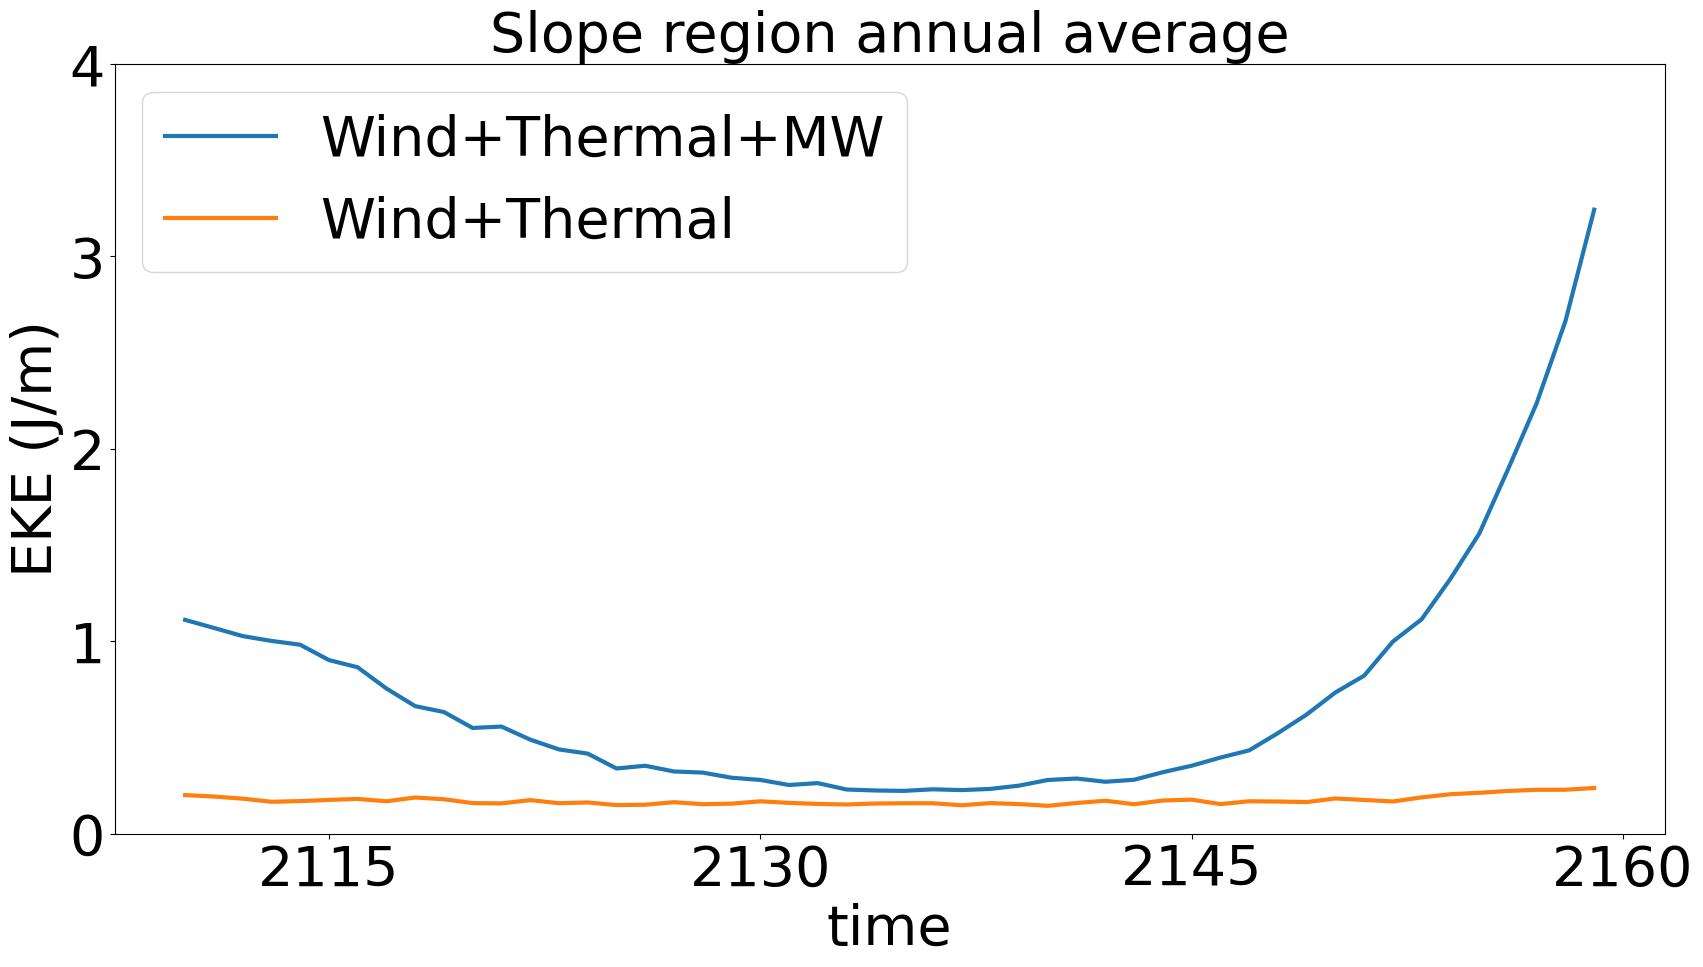

In [156]:
plt.figure(figsize = (20,10))
weighted_temporal_mean(EKE_wthmp).plot( label = 'Wind+Thermal+MW', lw =3)
weighted_temporal_mean(EKE_wthp).plot(label = 'Wind+Thermal', lw =3)
#weighted_temporal_mean(xr.merge(speed_ryf_mask_t)).plot(label = 'RYF', lw =3)
plt.ylabel('EKE (J/m$^3)')
plt.legend()
plt.ylim([0,4])
plt.title(region + ' annual average')

In [ ]:
plt.figure(figsize = (20,10))
(EKE_wthmp).EKE.plot( label = 'Wind+Thermal+MW', lw =3)
(EKE_wthp).EKE.plot(label = 'Wind+Thermal', lw =3)
#xr.merge(speed_ryf_coast_t).__xarray_dataarray_variable__.plot(label = 'RYF', lw =3)
plt.ylabel('EKE (J/m$^3$)')
plt.legend()
plt.ylim([0,4])
plt.title(region + ' annual average')

In [ ]:
## old code below

In [195]:
%%time
EKE_t = [grid.integrate(EKE_field.isel(time = slice(tt*1000,(tt+1)*1000)).where(largest_cluster_mask_xr == True), axis = ('X','Y')).load() for tt in range(1)]
EKE_t

CPU times: user 45.9 s, sys: 6.04 s, total: 51.9 s
Wall time: 2min 23s


[<xarray.Dataset>
 Dimensions:    (time: 1000)
 Coordinates:
   * time       (time) object 2000-01-01 12:00:00 ... 2002-09-27 12:00:00
     dayofyear  (time) int64 1 2 3 4 5 6 7 8 ... 263 264 265 266 267 268 269 270
 Data variables:
     EKE        (time) float64 1.223e+12 1.261e+12 ... 8.556e+11 8.557e+11,
 <xarray.Dataset>
 Dimensions:    (time: 1000)
 Coordinates:
   * time       (time) object 2002-09-28 12:00:00 ... 2005-06-24 12:00:00
     dayofyear  (time) int64 271 272 273 274 275 276 ... 170 171 172 173 174 175
 Data variables:
     EKE        (time) float64 8.459e+11 8.464e+11 ... 1.248e+12 1.258e+12,
 <xarray.Dataset>
 Dimensions:    (time: 1000)
 Coordinates:
   * time       (time) object 2005-06-25 12:00:00 ... 2008-03-21 12:00:00
     dayofyear  (time) int64 176 177 178 179 180 181 182 ... 74 75 76 77 78 79 80
 Data variables:
     EKE        (time) float64 1.26e+12 1.261e+12 ... 2.614e+12 2.624e+12,
 <xarray.Dataset>
 Dimensions:    (time: 1000)
 Coordinates:
   * time   

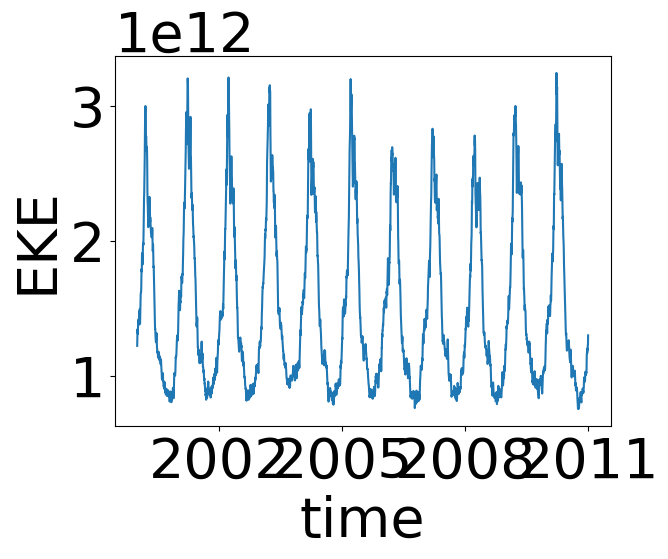

In [198]:
xr.concat(EKE_t, dim = 'time').EKE.plot()

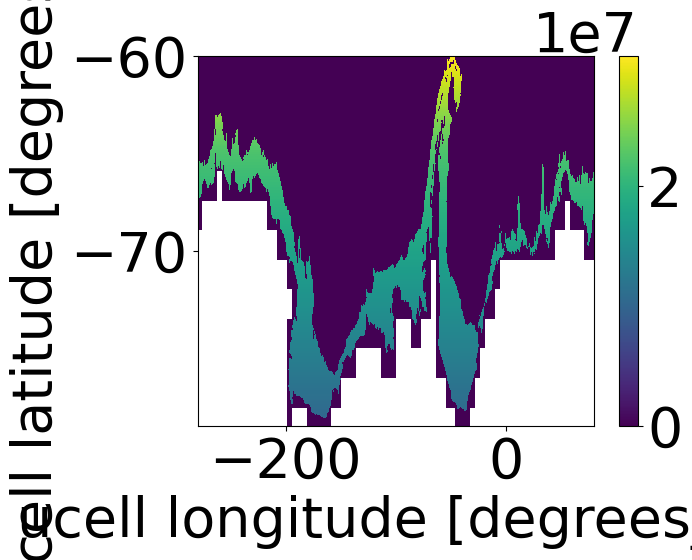

In [222]:
area_access = vel.area_u*largest_cluster_mask_xr
area_access.plot()

In [225]:
vel.area_u

<xarray.DataArray 'area_u' (yu_ocean: 440, xu_ocean: 3600)>
dask.array<where, shape=(440, 3600), dtype=float32, chunksize=(440, 900), chunktype=numpy.ndarray>
Coordinates:
  * xu_ocean  (xu_ocean) float64 -279.9 -279.8 -279.7 -279.6 ... 79.8 79.9 80.0
  * yu_ocean  (yu_ocean) float64 -78.98 -78.93 -78.89 ... -60.12 -60.07 -60.02
    geolon_c  (yu_ocean, xu_ocean) float32 dask.array<chunksize=(440, 900), meta=np.ndarray>
    geolat_c  (yu_ocean, xu_ocean) float32 dask.array<chunksize=(440, 900), meta=np.ndarray>
Attributes:
    long_name:     velocity cell area
    units:         m^2
    valid_range:   [0.e+00 1.e+15]
    cell_methods:  time: point

In [224]:
total_area_access = grid.integrate(area_access, axis = ('X','Y'))
total_area_access.values # [m2]

array(7.1356625e+19, dtype=float32)

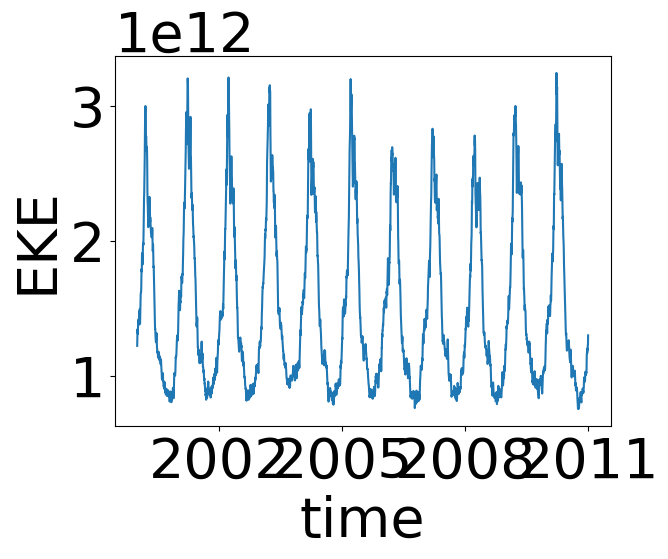

In [234]:
EKE_density_t =xr.concat(EKE_t, dim = 'time').EKE#/total_area_access
EKE_density_t.plot()

In [235]:
xr.concat(EKE_t, dim = 'time').to_netcdf(\
    '/g/data/v45/qo9901/RYF_plotting/EKE_t_ryf9091_accessom201_2500misobath_3cluster.nc')